In [1]:
import torch
print(torch.__version__)


2.5.0+cu124


In [15]:
import deepchem as dc
from rdkit import Chem

import pandas as pd
import numpy as np

In [16]:
rxrx19b_metadata = pd.read_csv('data/rxrx19b_metadata.csv', index_col=0)
rxrx19b_embeddings = pd.read_csv('data/rxrx19b_embeddings.csv', index_col=0)

In [17]:
X = rxrx19b_embeddings.values.tolist()

X_series = pd.Series(X, index=rxrx19b_embeddings.index, name='embeddings')
X_df = X_series.to_frame()

y = rxrx19b_metadata['SMILES']
y_df = y.to_frame()
X_df = X_df.loc[y.index]

In [18]:
X_df.head()

y_df.head()

,SMILES
site_id,
HUVEC-1_1_AA02_1,CN1N=CC=C1NC1=NC=CC(=N1)C1=CC(=O)N(C=C1)C(CO)C...
HUVEC-1_1_AA03_1,"CN1CCC(CC1)OC(C1=CC=CC=C1)C1=CC=CC=C1 |c:12,14..."
HUVEC-1_1_AA04_1,O=C1NC2=CC=CC=C2\C1=C1\NC2=C(C=CC=C2)C1=O |c:5...
HUVEC-1_1_AA05_1,C[C@H](NC(=O)CC1=CC(F)=CC(F)=C1)C(=O)N[C@H]1C2...
HUVEC-1_1_AA07_1,NCCS(O)(=O)=O


In [24]:
non_nan_indices = ~y_df['SMILES'].isna()
X_filtered = X_df[non_nan_indices]
y_filtered = y_df[non_nan_indices]



In [32]:
y_filtered

,SMILES
site_id,
HUVEC-1_1_AA02_1,CN1N=CC=C1NC1=NC=CC(=N1)C1=CC(=O)N(C=C1)C(CO)C...
HUVEC-1_1_AA03_1,"CN1CCC(CC1)OC(C1=CC=CC=C1)C1=CC=CC=C1 |c:12,14..."
HUVEC-1_1_AA04_1,O=C1NC2=CC=CC=C2\C1=C1\NC2=C(C=CC=C2)C1=O |c:5...
HUVEC-1_1_AA05_1,C[C@H](NC(=O)CC1=CC(F)=CC(F)=C1)C(=O)N[C@H]1C2...
HUVEC-1_1_AA07_1,NCCS(O)(=O)=O
...,...
HUVEC-1_53_Z41_1,COC1=CC(OC)=CC(NC2=NC3=CC=CC=C3N=C2NS(=O)(=O)C...
HUVEC-1_53_Z42_1,CN(C)CC[C@H](CSC1=CC=CC=C1)NC1=CC=C(C=C1[N+]([...
HUVEC-1_53_Z45_1,CCOC1=C(C(=O)NC2=CC=C(OC3=CC=NC(N)=C3Cl)C(F)=C...


In [33]:

smiles_list = y_filtered['SMILES'].tolist()

featurizer = dc.feat.Mol2VecFingerprint()
features = featurizer.featurize(smiles_list)
type(features)

Failed to featurize datapoint 73, None. Appending empty array
Exception message: Python argument types in
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True, bool includeAtomMaps=True, bool includeChiralPresence=False)
Failed to featurize datapoint 228, None. Appending empty array
Exception message: Python argument types in
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True, bool includeAtomMaps=True, bool includeChiralPresence=False)
Failed to featurize datapoint 254, None. Appending empty array
Exception message: Python argument types in
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(RDKit::ROMol mol, bool breakTies=True, bool inclu

numpy.ndarray

In [34]:
y_filtered['features'] = features


/tmp/ipykernel_9089/3876801190.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_filtered['features'] = features


In [68]:
vector_sizes = y_filtered['features'].apply(len)
size_counts = vector_sizes.value_counts()
print(size_counts)


features
300    64272
0        312
Name: count, dtype: int64


In [69]:
data = pd.merge(X_filtered, y_filtered, on='site_id')
data.head()

data = data[data['features'].apply(len) > 0]


In [70]:
assert data['embeddings'].apply(len).eq(128).all(), "All embeddings should be of length 104"
assert data['features'].apply(len).eq(300).all(), "All features should be of length 300"

In [72]:
X_features = np.vstack(data['embeddings'].values)
Y_features = np.vstack(data['features'].values)

print(f"Input features shape: {X_features.shape}")
print(f"Target features shape: {Y_features.shape}")


Input features shape: (64272, 128)
Target features shape: (64272, 300)


In [73]:
# Convert to tensors
X_tensor = torch.from_numpy(X_features).float()
Y_tensor = torch.from_numpy(Y_features).float()


print(f"X_tensor shape: {X_tensor.shape}")
print(f"Y_tensor shape: {Y_tensor.shape}")


X_tensor shape: torch.Size([64272, 128])
Y_tensor shape: torch.Size([64272, 300])


In [74]:
from sklearn.model_selection import train_test_split

X_train, X_temp, Y_train, Y_temp = train_test_split(X_tensor, Y_tensor, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Training set size: 44990
Validation set size: 9641
Test set size: 9641


In [75]:
from torch.utils.data import Dataset, DataLoader  

class EmbeddingDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


train_dataset = EmbeddingDataset(X_train, Y_train)
val_dataset = EmbeddingDataset(X_val, Y_val)
test_dataset = EmbeddingDataset(X_test, Y_test)


batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [77]:
import torch.nn as nn
import torch.optim as optim


class ImageToMol2VecModel(nn.Module):
    def __init__(self):
        super(ImageToMol2VecModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 300)
        )
        
    def forward(self, x):
        return self.model(x)

model = ImageToMol2VecModel()


In [78]:

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = model.to(device)



Using device: cuda


In [79]:
num_epochs = 50
best_val_loss = float('inf')
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    
    model.train()
    running_loss = 0.0
    for batch_X, batch_Y in train_loader:
        batch_X = batch_X.to(device)
        batch_Y = batch_Y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_Y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * batch_X.size(0)
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    # Validation Phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_X, val_Y in val_loader:
            val_X = val_X.to(device)
            val_Y = val_Y.to(device)
            val_outputs = model(val_X)
            loss = criterion(val_outputs, val_Y)
            val_loss += loss.item() * val_X.size(0)
    epoch_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")
    
    # Early Stopping and Saving Best Model
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), 'best_model.pth')


Epoch 1/50, Training Loss: 12.5945, Validation Loss: 11.3724
Epoch 2/50, Training Loss: 11.8809, Validation Loss: 11.0535
Epoch 3/50, Training Loss: 11.7293, Validation Loss: 11.0324
Epoch 4/50, Training Loss: 11.6081, Validation Loss: 11.2342
Epoch 5/50, Training Loss: 11.4776, Validation Loss: 10.8805
Epoch 6/50, Training Loss: 11.3946, Validation Loss: 11.0390
Epoch 7/50, Training Loss: 11.3358, Validation Loss: 10.9154
Epoch 8/50, Training Loss: 11.2898, Validation Loss: 10.7780
Epoch 9/50, Training Loss: 11.2542, Validation Loss: 10.7603
Epoch 10/50, Training Loss: 11.2240, Validation Loss: 10.7867
Epoch 11/50, Training Loss: 11.1953, Validation Loss: 10.7684
Epoch 12/50, Training Loss: 11.1880, Validation Loss: 10.7048
Epoch 13/50, Training Loss: 11.1420, Validation Loss: 10.6899
Epoch 14/50, Training Loss: 11.1648, Validation Loss: 10.6850
Epoch 15/50, Training Loss: 11.1259, Validation Loss: 10.7700
Epoch 16/50, Training Loss: 11.1153, Validation Loss: 10.6650
Epoch 17/50, Trai

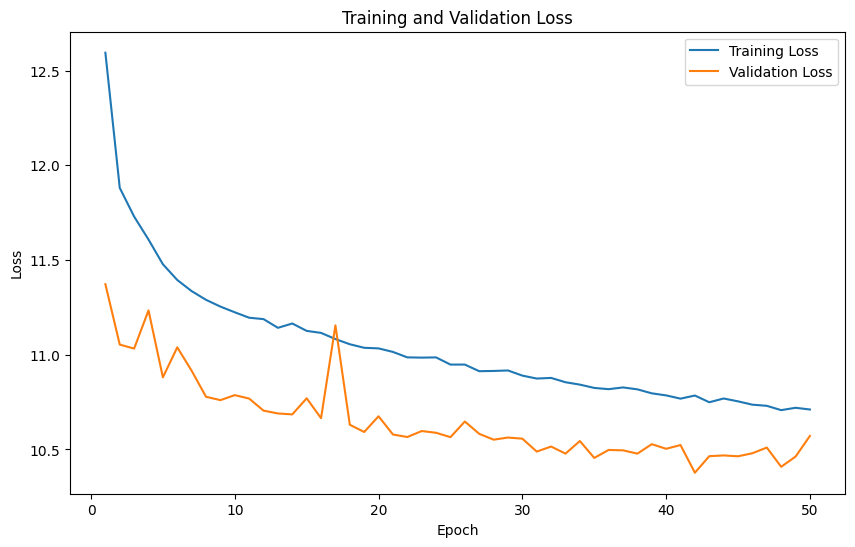

In [80]:
# Plot training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [82]:
from sklearn.metrics.pairwise import cosine_similarity

model.eval()
test_loss = 0.0
cosine_sim = 0.0
num_batches = 0

all_test_outputs = []
all_test_targets = []

with torch.no_grad():
    for test_X, test_Y in test_loader:
        test_X = test_X.to(device)
        test_Y = test_Y.to(device)
        test_outputs = model(test_X)
        loss = criterion(test_outputs, test_Y)
        test_loss += loss.item() * test_X.size(0)
        
        # Move data to CPU for calculation
        test_outputs_cpu = test_outputs.cpu().numpy()
        test_Y_cpu = test_Y.cpu().numpy()
        
        all_test_outputs.append(test_outputs_cpu)
        all_test_targets.append(test_Y_cpu)
        
        cosine_sim += cosine_similarity(test_outputs_cpu, test_Y_cpu).mean()
        num_batches += 1

test_loss /= len(test_loader.dataset)
cosine_sim /= num_batches

print(f"Test Loss: {test_loss:.4f}")
print(f"Average Cosine Similarity: {cosine_sim:.4f}")


Test Loss: 11.0507
Average Cosine Similarity: 0.9043


ImportError: cannot import name 'PCA' from 'pca' (/opt/miniconda/envs/deep/lib/python3.10/site-packages/pca/__init__.py)